***IMPORTANTE:*** allegare al colab il dataset "liar_dataset.csv" che si può trovare nella consegna

# Import

In [4]:
!pip install transformers shap torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [6]:
!pip install -U datasets pyampute bert-score nltk wordcloud sentence-transformers umap-learn plotly lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=21e8011a722f630f244e1b4fdfe52c44be7b6ce77d8dfaa40e45b0d871ef0a24
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Succ

In [1]:
import datasets
import shap
import torch
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import umap.umap_ as umap
import plotly.express as px

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from itertools import combinations
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load dataset

In [2]:
label_map = {0: 'pants-fire', 1: 'false', 2: 'mostly-false', 3: 'half-true', 4: 'mostly-true', 5: 'true'}
label_convert = {'pants-fire': 0, 'false': 1, 'mostly-false': 2, 'half-true': 3, 'mostly-true': 4, 'true':5}

In [3]:
disinfo_map = {0: 'truth', 1: 'disinformation'}
disinfo_convert = {'truth': 0, 'disinformation': 1}

In [4]:
liar_dataset = pd.read_csv('liar_dataset.csv')

# distinguish semantic patterns between different types of classification

In [18]:
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(liar_dataset["statement"].tolist(), show_progress_bar=True, normalize_embeddings=True) # Normalize is used to make the cosine more robust
# embeddings = np.load('embeddings_sbert.npy')

In [19]:
sentences = liar_dataset["statement"].tolist()
print(f"Number of input sentences: {len(sentences)}")
print(f"Number of embeddings generated: {len(embeddings)}")

Number of input sentences: 22593
Number of embeddings generated: 22593


## UMAP

In [20]:
# UMAP: 3-dimensional reduction for visualization
umap_model = umap.UMAP(n_neighbors=15, n_components=3, random_state=42)
embedding_3d_umap = umap_model.fit_transform(embeddings)

liar_dataset["x"] = embedding_3d_umap[:, 0]
liar_dataset["y"] = embedding_3d_umap[:, 1]
liar_dataset["z"] = embedding_3d_umap[:, 2]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
liar_dataset["label_name"] = liar_dataset["label"].map(label_map)

fig = px.scatter_3d(
    liar_dataset,
    x="x", y="y", z="z",
    color="label_name",
    title="Mappa semantica 3D delle affermazioni (UMAP + SBERT)",
    hover_data={"speaker": True, "statement": True, "label_name": True, "x": False, "y": False, "z": False},
    color_discrete_sequence=px.colors.qualitative.Safe,
    opacity=0.7
)

fig.update_traces(marker=dict(size=3))
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [32]:
liar_dataset["disinfo_name"] = liar_dataset["disinfo"].map(disinfo_map)

fig = px.scatter_3d(
    liar_dataset,
    x="x", y="y", z="z",
    color="disinfo_name",
    title="Mappa semantica 3D delle affermazioni (UMAP + SBERT)",
    hover_data={"speaker": True, "statement": True, "disinfo_name": True, "x": False, "y": False, "z": False},
    color_discrete_sequence=px.colors.qualitative.Safe,
    opacity=0.7
)

fig.update_traces(marker=dict(size=3))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Cosine Similarity

In [23]:
intra_class_similarities_label = []
intra_class_similarities_disinfo = []

for label in sorted(liar_dataset['label'].unique()):
    mask = liar_dataset['label'] == label
    label_embeddings = embeddings[mask]

    cos_sim_matrix = cosine_similarity(label_embeddings)
    mean_sim = cos_sim_matrix.mean()
    intra_class_similarities_label.append((label, label, mean_sim))

for disinfo in sorted(liar_dataset['disinfo'].unique()):
    mask = liar_dataset['disinfo'] == disinfo
    disinfo_embeddings = embeddings[mask]

    cos_sim_matrix = cosine_similarity(disinfo_embeddings)
    mean_sim = cos_sim_matrix.mean()
    intra_class_similarities_disinfo.append((disinfo, disinfo, mean_sim))

In [24]:
inter_class_similarities_label = []
labels = sorted(liar_dataset['label'].unique())
for label1, label2 in combinations(labels, 2):
    emb1 = embeddings[liar_dataset['label'] == label1]
    emb2 = embeddings[liar_dataset['label'] == label2]

    cos_sim_matrix = cosine_similarity(emb1, emb2)
    mean_sim = cos_sim_matrix.mean()

    inter_class_similarities_label.append((label1, label2, mean_sim))
    inter_class_similarities_label.append((label2, label1, mean_sim))

inter_class_similarities_disinfo = []
disinfos = sorted(liar_dataset['disinfo'].unique())
for disinfo1, disinfo2 in combinations(disinfos, 2):
    emb1 = embeddings[liar_dataset['disinfo'] == disinfo1]
    emb2 = embeddings[liar_dataset['disinfo'] == disinfo2]

    cos_sim_matrix = cosine_similarity(emb1, emb2)
    mean_sim = cos_sim_matrix.mean()

    inter_class_similarities_disinfo.append((disinfo1, disinfo2, mean_sim))
    inter_class_similarities_disinfo.append((disinfo2, disinfo1, mean_sim))

In [25]:
all_class_similarities = intra_class_similarities_label + inter_class_similarities_label

class_df = pd.DataFrame(all_class_similarities, columns=['label1', 'label2', 'mean_similarity'])
class_pivot = class_df.pivot(index='label1', columns='label2', values='mean_similarity')

class_pivot = class_pivot.sort_index(axis=0).sort_index(axis=1)

class_pivot.index = class_pivot.index.map(label_map)
class_pivot.columns = class_pivot.columns.map(label_map)

fig = px.imshow(
    class_pivot,
    labels=dict(x="Label 2", y="Label 1", color="Average similarity"),
    x=class_pivot.columns,
    y=class_pivot.index,
    text_auto=".4f",
    color_continuous_scale="Viridis",
    title="Class Average Similarity Matrix (Cosine Similarity)"
)

fig.update_layout(
    xaxis_title="Label 2",
    yaxis_title="Label 1"
)

fig.show()

In [26]:
all_class_similarities = intra_class_similarities_disinfo + inter_class_similarities_disinfo

class_df = pd.DataFrame(all_class_similarities, columns=['label1', 'label2', 'mean_similarity'])
class_pivot = class_df.pivot(index='label1', columns='label2', values='mean_similarity')

class_pivot = class_pivot.sort_index(axis=0).sort_index(axis=1)

class_pivot.index = class_pivot.index.map(disinfo_map)
class_pivot.columns = class_pivot.columns.map(disinfo_map)

fig = px.imshow(
    class_pivot,
    labels=dict(x="Label 2", y="Label 1", color="Average similarity"),
    x=class_pivot.columns,
    y=class_pivot.index,
    text_auto=".4f",
    color_continuous_scale="Viridis",
    title="Class Average Similarity Matrix (Cosine Similarity)"
)

fig.update_layout(
    xaxis_title="Label 2",
    yaxis_title="Label 1"
)

fig.show()

## Silhouette score

In [27]:
labels = liar_dataset["label"].tolist()
score = silhouette_score(embeddings, labels, metric='cosine')

print(f'Silhouette score (cosine): {score:.4f}')

Silhouette score (cosine): -0.0122


In [28]:
disinfos = liar_dataset["disinfo"].tolist()
score = silhouette_score(embeddings, disinfos, metric='cosine')

print(f'Silhouette score (cosine): {score:.4f}')

Silhouette score (cosine): 0.0096


# Global explanations on the classification of statements

In [5]:
label_names = ['pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true']
config = AutoConfig.from_pretrained(
    "distilbert-base-cased",
    num_labels=len(label_names),
    id2label={i: label for i, label in enumerate(label_names)},
    label2id={label: i for i, label in enumerate(label_names)}
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", config=config)
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=True
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
explainer = shap.Explainer(pipe)
test_texts = liar_dataset['statement'].tolist()[:50] # 50 per questioni di computazioni
shap_values = explainer(test_texts)

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 1/50 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 3/50 [01:31<19:17, 24.63s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [01:56<18:58, 24.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [02:36<23:01, 30.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [03:23<26:34, 36.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [04:02<26:34, 37.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [04:46<27:39, 39.50s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [05:05<22:25, 32.82s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 10/50 [05:19<18:05, 27.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [06:08<22:03, 33.94s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [06:29<18:59, 29.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [07:38<25:38, 41.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [08:14<23:54, 39.84s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [08:48<22:12, 38.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [09:31<22:35, 39.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [10:13<22:07, 40.23s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [10:35<18:36, 34.88s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 19/50 [10:43<13:52, 26.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 20/50 [11:32<16:45, 33.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 21/50 [12:07<16:22, 33.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 22/50 [12:46<16:30, 35.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 23/50 [13:25<16:28, 36.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [14:10<16:56, 39.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [14:51<16:30, 39.62s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [15:24<15:01, 37.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [16:10<15:20, 40.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 28/50 [16:51<14:48, 40.37s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [17:02<11:01, 31.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [17:39<11:03, 33.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [18:40<13:10, 41.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [19:28<13:05, 43.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [20:09<12:08, 42.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 34/50 [20:54<11:31, 43.25s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [21:27<10:03, 40.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [22:21<10:21, 44.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [23:07<09:43, 44.89s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 38/50 [23:20<07:03, 35.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [24:01<06:47, 37.05s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [24:28<05:40, 34.00s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [25:04<05:11, 34.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [25:51<05:06, 38.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 43/50 [26:31<04:33, 39.05s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 44/50 [27:07<03:47, 37.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [27:52<03:20, 40.14s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 46/50 [28:05<02:07, 31.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [29:07<02:02, 40.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [30:11<01:36, 48.05s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 49/50 [30:47<00:44, 44.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 50/50 [31:47<00:00, 48.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [32:26, 38.92s/it]


In [8]:
shap.plots.text(shap_values)

Output hidden; open in https://colab.research.google.com to view.


Importanza globale – Classe pants-fire:


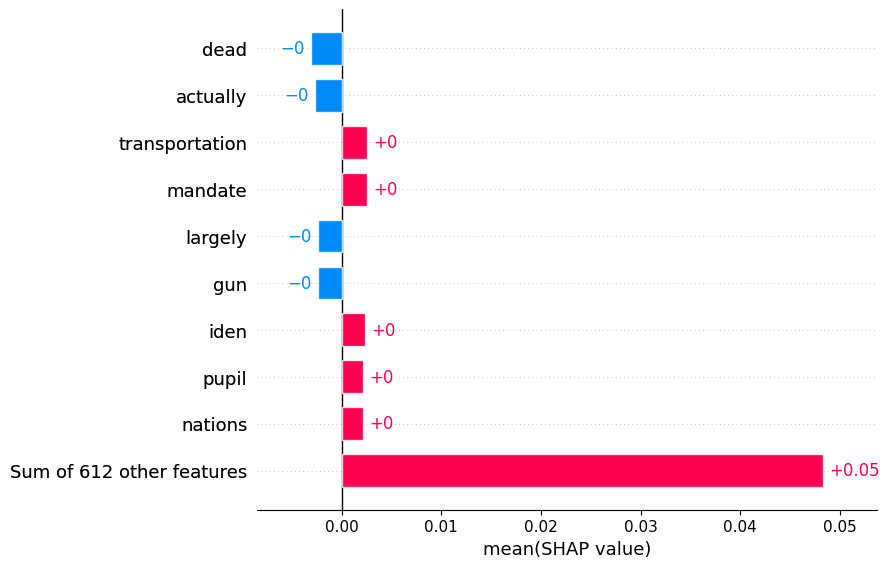


Importanza globale – Classe false:


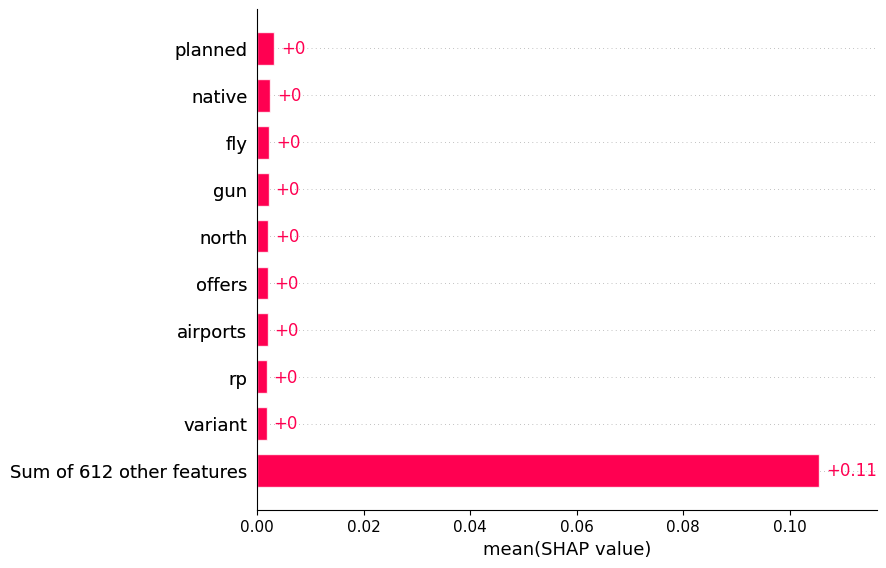


Importanza globale – Classe mostly-false:


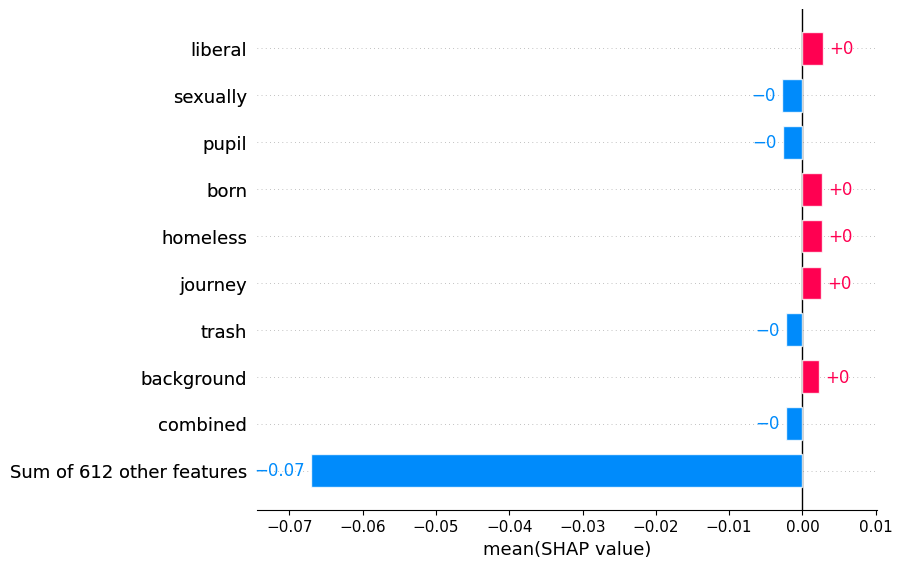


Importanza globale – Classe half-true:


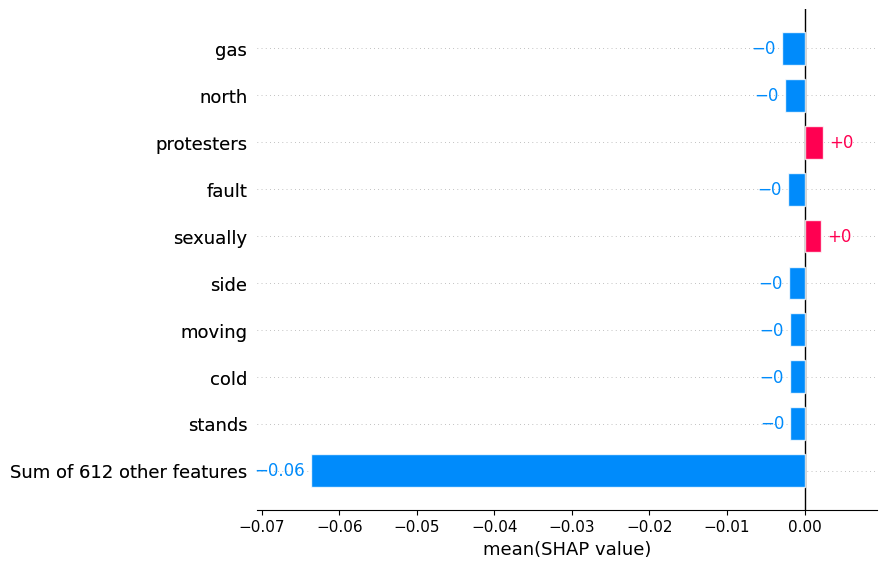


Importanza globale – Classe mostly-true:


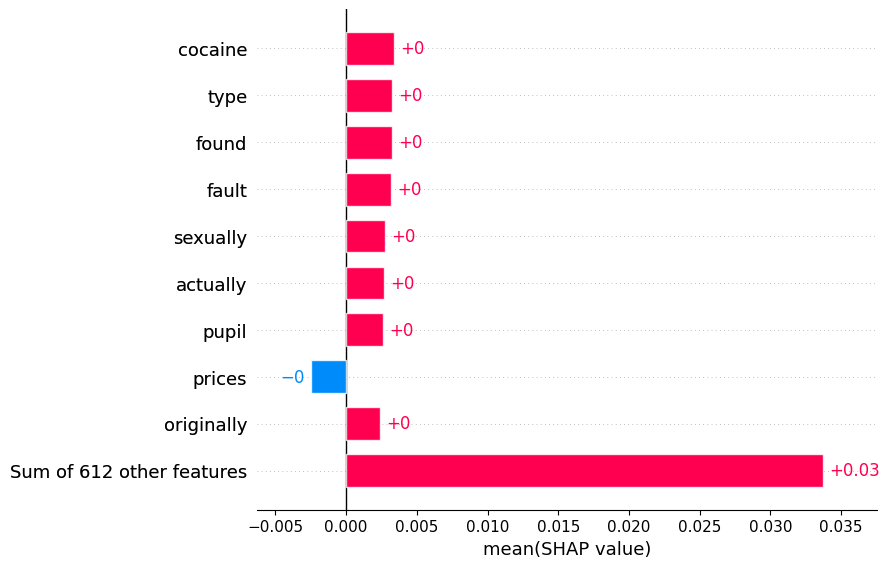


Importanza globale – Classe true:


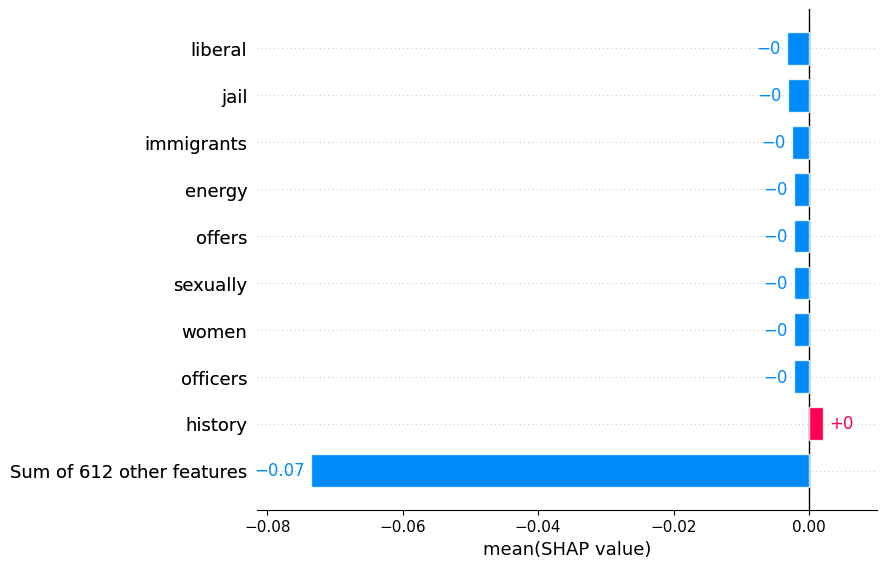

In [9]:
for lbl in label_names:
    print(f"\nImportanza globale – Classe {lbl}:")
    shap.plots.bar(shap_values[:, :, lbl].mean(0), max_display=10)

In [10]:
for i, text in enumerate(test_texts):
    print(f"\nTop token per la frase: '{text}'")
    tokens = shap_values.data[i]
    for lbl in label_names:
        mean_vals = shap_values[i, :, lbl].values
        top_idx = np.argsort(np.abs(mean_vals))[-10:][::-1]
        top_feats = [(tokens[i], mean_vals[i]) for i in top_idx]
        print(f"{lbl}: {top_feats}")


Top token per la frase: '90 percent of Americans "support universal background checks" for gun purchases.'
pants-fire: [('gun ', np.float64(-0.0023804279044270515)), ('Americans ', np.float64(0.0015517892315983772)), ('background ', np.float64(-0.0013975882902741432)), ('universal ', np.float64(0.0013828445225954056)), ('for ', np.float64(0.0013155266642570496)), ('purchases', np.float64(0.0011507226154208183)), ('percent ', np.float64(0.0009024553000926971)), ('checks', np.float64(0.0008071800693869591)), ('"', np.float64(0.000798533670604229)), ('support ', np.float64(-0.0007666405290365219))]
false: [('gun ', np.float64(0.002179405651986599)), ('background ', np.float64(-0.0017192093655467033)), ('Americans ', np.float64(-0.001171732321381569)), ('purchases', np.float64(0.0008576223626732826)), ('percent ', np.float64(-0.0008521480485796928)), ('.', np.float64(-0.0007052607834339142)), ('universal ', np.float64(0.0006539681926369667)), ('" ', np.float64(0.0005751904100179672)), ('o